## Hw1. Autoencoder (with convolution)
- 실습때 진행했던 Autoencoder를 Convolutional Autoencoder로 구현
- 사용 데이터는 실습과 동일한 FashionMNIST로 진행
- CAE를 통과하면 데이터는 (1, 28, 28) -> (32, 14, 14) -> (64, 7, 7) -> (32, 14, 14) -> (1, 28, 28) 로 변경
- 최종 CAE를 거치면 다시 복원된 데이터가 나오게 됨.
- 실습 때 진행했던 기본 Autoencoder에 비해 대체적으로 정확도 높게 잘 나오는 것으로 확인됨.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed(777)

cpu


In [3]:
fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

fashion_train.data = fashion_train.data / 255.0
fashion_train.targets = fashion_train.targets
fashion_test.data = fashion_test.data / 255.0
fashion_test.targets = fashion_test.targets

tensor(0)


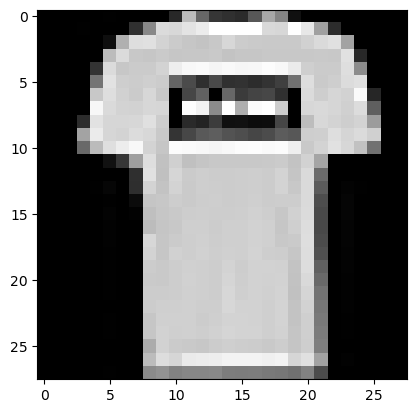

In [4]:
plt.imshow(fashion_train.data[1], cmap="gray")
print(fashion_train.targets[1])

In [5]:
batch_size = 256

train_loader = DataLoader(dataset=fashion_train.data, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset=fashion_test.data, batch_size=len(fashion_test.data), shuffle=False, drop_last=False)

torch.Size([256, 28, 28])
torch.Size([28, 28])


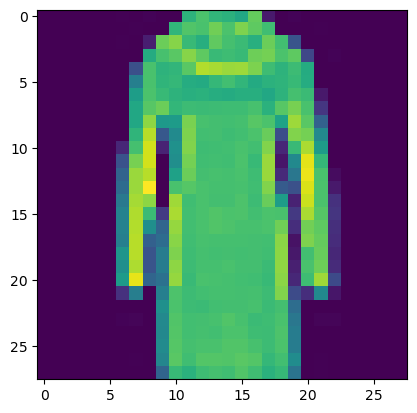

In [6]:
# print dataset form and image

for i, data in enumerate(train_loader):
    x = data
    # print(y.shape)
    print(x.shape) # batch_size, channel, width, height
    print(x[0].shape)
    # print(y[0])
    plt.imshow(x[0])
    break

In [7]:
## Convolutional layers - for check
conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
# conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

# conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
conv5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
conv6 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)

print(conv1)
print(conv2)
# print(conv3)

# print(conv4)
print(conv5)
print(conv6)

pool = nn.MaxPool2d(2, 2)
input_data = torch.Tensor(batch_size, 1, 28, 28)
print("input: ", input_data.shape)

pc1 = conv1(input_data)
print("pass conv1: ", pc1.shape)

pc2 = conv2(pc1)
print("pass conv2: ", pc2.shape)

# pc3 = conv3(pc2)
# print("pass conv3: ", pc3.shape)

# pool = nn.MaxPool2d(2)
# print(conv1(input_data)).shape

# pool3 = nn.MaxPool2d(3)
# final_output = conv3(pool(conv2(pool(conv1(input_data)))))
# print("middle result : ", final_output.shape)

final_output = conv5(pc2)
print("reconv1: ", final_output.shape)

# final_output = conv5(final_output)
# print(final_output.shape)

final_output = conv6(final_output)
print(final_output.shape)

# final_output = pool3(final_output)
# final_output = conv6(conv5(conv4(final_output)))
# print(final_output.shape)

out = final_output.view(final_output.shape[0], -1)
# print(out.shape)

# fc = nn.Linear(256, 2048)
# fc(out).shape

Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
input:  torch.Size([256, 1, 28, 28])
pass conv1:  torch.Size([256, 32, 14, 14])
pass conv2:  torch.Size([256, 64, 7, 7])
reconv1:  torch.Size([256, 32, 14, 14])
torch.Size([256, 1, 28, 28])


In [8]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    
    # encoder
    self.encoderlayer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.LeakyReLU())
        
    self.encoderlayer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.LeakyReLU())

    # decoder
    self.decoderlayer2 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                                       nn.BatchNorm2d(32),
                                       nn.LeakyReLU())
    
    self.decoderlayer3 = nn.Sequential(nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
                                       nn.BatchNorm2d(1),
                                       nn.LeakyReLU())


  def forward(self, x):
    out = self.encoderlayer1(x)
    out = self.encoderlayer2(out)
    out = self.decoderlayer2(out)
    output = self.decoderlayer3(out)

    return torch.sigmoid(output)

In [9]:
model = Autoencoder().to(device)
model

Autoencoder(
  (encoderlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (encoderlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (decoderlayer2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (decoderlayer3): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
)

In [10]:
num_epochs = 10
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
loss_list = []

for epoch_num in range(num_epochs):
  average_cost = 0

  for batch_idx, images in enumerate(train_loader):
    num_of_mini_batch = len(train_loader)

    images = images.to(device)
#     print(images.shape)
    input_image = images.unsqueeze(1) # 차원 생성 [256, 28, 28] -> [256, 1, 28, 28] 로 변경
    optimizer.zero_grad()
    y_predict = model(input_image)
    loss = criterion(y_predict, input_image)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item() / num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

Epoch 1 Loss 0.14701
Epoch 2 Loss 0.14172
Epoch 3 Loss 0.14130
Epoch 4 Loss 0.14098
Epoch 5 Loss 0.14067
Epoch 6 Loss 0.14034
Epoch 7 Loss 0.13999
Epoch 8 Loss 0.13963
Epoch 9 Loss 0.13926
Epoch 10 Loss 0.13890


In [12]:
for batch_idx, image in enumerate(test_loader):
  with torch.no_grad():
    test_img = image.unsqueeze(1).to(device)
    test_recon_x = model(test_img)

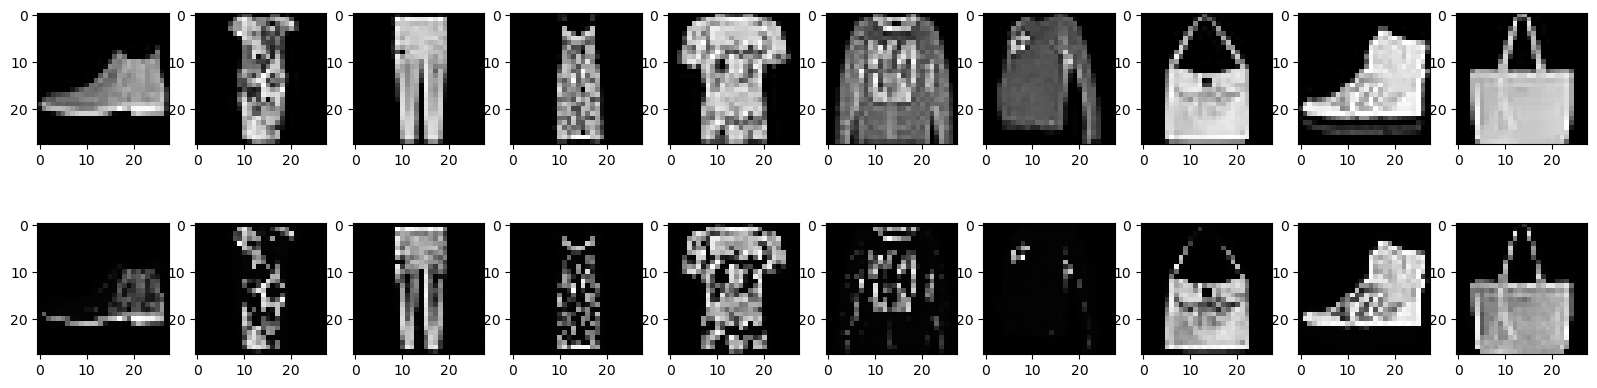

In [13]:
n = 10
plt.figure(figsize=(20, 5))

for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    test_img = image[i * 100].to(device)
    plt.imshow(test_img.cpu(), cmap='gray') # original image

    ax = plt.subplot(2, 10, i + 1 + n)
    recon_image = test_recon_x.data[i * 100].reshape(28, 28)
    plt.imshow(recon_image.cpu(), cmap='gray') # reconstruct image

## Hw2. Variational Autoencoder (VAE)
- 실습과 동일한 데이터를 사용하며, 중간 (400, 200) 의 layer를 하나 추가하여 모델 구성함.
- latent space의 차원도 20 -> 5로 바꿔 모델 구성.
- epoch 수도 10 -> 20으로 늘려서 학습 진행.
- 결과를 비교해봤을 때, latent space 의 차원을 20 -> 5로 변경하니 좀 더 흐릿한 결과를 확인할 수 있다.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed(777)

cpu


In [16]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [17]:
batch_size = 256

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.mu = nn.Linear(200, 5)
        self.logvar = nn.Linear(200, 5)
        self.fc3 = nn.Linear(5, 200)
        self.fc4 = nn.Linear(200, 400)
        self.fc5 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.leaky_relu(self.fc1(x))
        h1 = F.leaky_relu(self.fc2(h))
        mu = self.mu(h1)
        logvar = self.logvar(h1)

        return mu, logvar

    def reparameterize(self, mu_vector, logvar_vector):
        var_vector = torch.exp(logvar_vector)
        std = torch.sqrt(var_vector)
        eps = torch.randn_like(std)
        z_vector = mu_vector + eps.mul(std)

        return z_vector

    def decode(self, z):
        h = F.leaky_relu(self.fc3(z))
        h2 = F.leaky_relu(self.fc4(h))
        Bernouhlli_p = torch.sigmoid(self.fc5(h2))

        return Bernouhlli_p

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        Bernouhlli_p = self.decode(z)

        return Bernouhlli_p, mu, logvar

In [19]:
model = VAE().to(device)
model

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (mu): Linear(in_features=200, out_features=5, bias=True)
  (logvar): Linear(in_features=200, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)

In [20]:
def loss_function(recon_x, x, mu, logvar):
    Bernouhlli_loss = F.binary_cross_entropy(recon_x, x.reshape(-1, 784), reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return Bernouhlli_loss + KL_divergence

In [21]:
num_epochs = 20
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
loss_list = []

for epoch_num in range(num_epochs):
  average_cost = 0

  for batch_idx, (images, label) in enumerate(train_loader):
    num_of_mini_batch = len(train_loader)

    images = images.to(device)
    input_image = images.reshape(-1, 28 * 28)
    optimizer.zero_grad()
    recon_x, mu, logvar = model(input_image)
    loss = loss_function(recon_x, input_image, mu, logvar)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item() / num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

Epoch 1 Loss 50643.09675
Epoch 2 Loss 36629.68449
Epoch 3 Loss 34367.08564
Epoch 4 Loss 33401.91329
Epoch 5 Loss 32770.41294
Epoch 6 Loss 32312.02927
Epoch 7 Loss 31964.72499
Epoch 8 Loss 31676.79771
Epoch 9 Loss 31419.76447
Epoch 10 Loss 31190.36444
Epoch 11 Loss 30970.29001
Epoch 12 Loss 30761.34540
Epoch 13 Loss 30587.79033
Epoch 14 Loss 30428.59260
Epoch 15 Loss 30273.46923
Epoch 16 Loss 30134.21841
Epoch 17 Loss 30017.08731
Epoch 18 Loss 29900.66598
Epoch 19 Loss 29797.88323
Epoch 20 Loss 29700.52860


In [23]:
for batch_idx, (image, label) in enumerate(test_loader):
  with torch.no_grad():
    test_img = image.reshape(-1, 784).to(device)
    test_recon_x, _, _ = model(test_img)

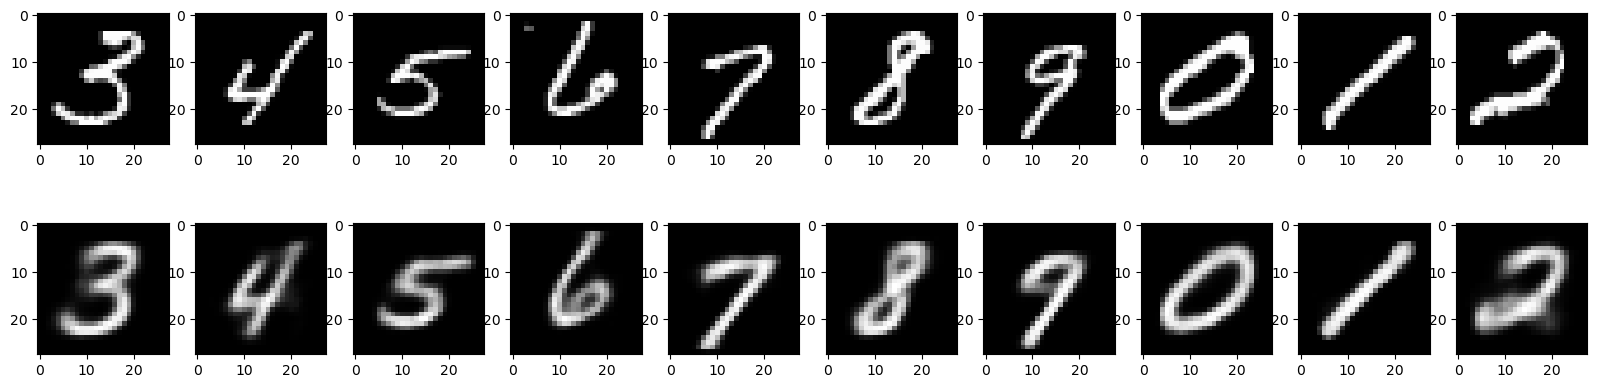

In [24]:
n = 10
plt.figure(figsize=(20, 5))

for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    image = test_img[i].reshape(28, 28)
    plt.imshow(image.cpu(), cmap='gray')

    ax = plt.subplot(2, 10, i + 1 + n)
    recon_image = test_recon_x.data[i].reshape(28, 28)
    plt.imshow(recon_image.cpu(), cmap='gray')

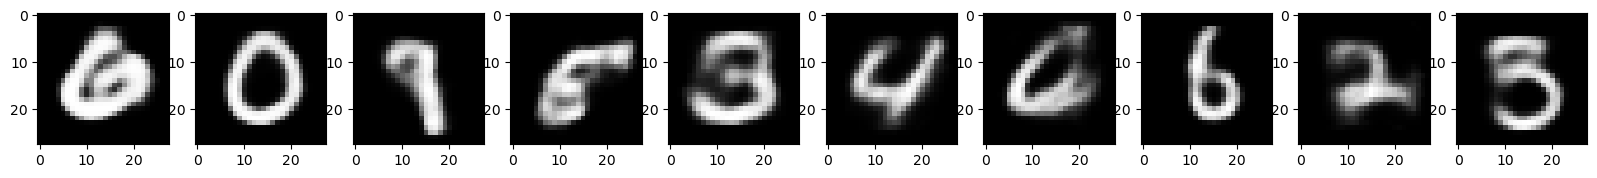

In [25]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    with torch.no_grad():
        sample_z = torch.randn(5).to(device)
        input_z = sample_z
        sample = model.decode(input_z).cpu()
        plt.imshow(sample.reshape(28, 28), cmap='gray')